## Task Description

The goal of this exercise is to model the relationship between weather observations and the amounts of cyclists in the city of Vienna.

To investigate a potential relationship, we will use two datasets:
 * tri-daily weather reports from 2009 - 2023 of Vienna.
 * daily cyclists in Vienna from 2021 - 2022.

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually analyse data,
 * use `scikit-learn` to build prediction models.

The data to be used can be found in the provided paths

To complete this exercise, you will have to:
* prepare the data, which (at minimum) involves the following:
    - load and prepare the data
    - handling missing values
    - handling outliers
    - temporal alignment of the two datasets
* analyse the data:
    - compare descriptive statistics
    - visually investigate the raw data to gain an understanding of the data identify patterns, outliers etc.,
 

**As this is a practice notebook, we are showing you all hidden tests, during the exams they will not be visible**


**Keep in mind that the exam also tests different aspects of Data Processing then this notebook does, and contains more programming and multiple choice questions**

In [1]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
import pickle
import typing


In [2]:
data_path = os.path.join(os.environ["HOME"], "shared", "194.192-2025W", "data", "cyclists")
weather_data_path = os.path.join(data_path, 'weather')
cyclists_data_path = os.path.join(data_path, 'cyclists')

## Data Loading

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) datasets from the csv files in `data/weather/` into a single `pd.DataFrame` and return it. 

- make sure that you load all the data (2009-2023, 15 years)
- split the tri-daily and daily data (tri-daily data has _7h, _14h, and _19h suffixes for column headers), and convert the tri-daily data from a wide to a long format (use pandas' [wide_to_long](https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html) or [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt) functions). Introduce a new `hours` column which's values should be taken from the column suffixes.
- make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!
- from the `date` column create `year`, `month`, `day` columns. Use Pandas built-in datetime handling features.
- from the wide to long transform, you should have an `hour` column with the 7, 14, or 19 hours values.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `day` - `hour` (make sure to label them accordingly)

**Hints:**
 
 - LOOK at the data in the original files
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Note that for the `precip` data column you will get an unexpected (object) datatype. For this task it is ok to leave it like that, it is due to special values, see next chapters!
 - You will find similar names, in the disruption column, you are free to combine them to reduce the number of different disruptions.
 - Your resulting data frame should look as follows, with temperature in Celsius, air pressure in hecto Pascal, skyCover on a scale from 1-10, humidity in percent, windDir in compass directions, windBeauf in Beaufort and precip in millimeters.: ![alt text](img.png "Dataframe")

In [3]:
def load_weather_data(weather_data_path:str) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Split the tri-daily data from the daily data.
    For the tri-daily data create a new hour column using the indicated hour in the column names.
    Add a hierarchical index (year, month, day, hour).
    For the daily-only data also add a hierarchical index (year, month, day).
    
    Parameters
    --------
    weather_data_path: path to directory containing weather data CSV files
    
    Returns
    --------
    weather_data: data frame containing the tri-daily (hours) weather data
    weather_data_daily: data frame containing the daily weather data (e.g. precip, precipType, etc.)
    """

    # YOUR CODE HERE
    csv_files = glob.glob(os.path.join(weather_data_path, "*.csv"))
    df_list = [pd.read_csv(file,sep=";") for file in csv_files]
    combined_df = pd.concat(df_list, ignore_index=True)

    combined_df["date"] = pd.to_datetime(combined_df["date"],format="%d.%m.%Y")
    combined_df["year"] = combined_df["date"].dt.year
    combined_df["month"] = combined_df["date"].dt.month
    combined_df["day"] = combined_df["date"].dt.day

    weather_data = combined_df
    stubs = ["airPressure","skyCover","temp","hum","windDir","windBeauf"]
    weather_data = pd.wide_to_long(weather_data, stubs, i="date",j="hour",sep="_",suffix=r"\d+h")
    weather_data = weather_data.reset_index()


    #type conversion
    # make hour an integer
    weather_data["hour"] = (
        weather_data["hour"]
        .astype(str)
        .str.extract(r"(\d+)", expand=False)
        .astype(int)
    )
    
    # make sure year, month, day are ints too
    weather_data["year"] = weather_data["year"].astype(int)
    weather_data["month"] = weather_data["month"].astype(int)
    weather_data["day"] = weather_data["day"].astype(int)
    
    
    weather_data = weather_data.set_index(["year", "month", "day", "hour"]).sort_index()

    weather_data_daily = weather_data.drop(labels=stubs,axis=1)
    weather_data = weather_data.drop(labels=["precip","precipType"],axis=1)

    col = weather_data_daily.pop("precip")
    weather_data_daily["precip"]=col

    #fahrenheit conversion
    weather_data["temp"] = (weather_data["temp"] - 32) * 5/9
    
    return weather_data, weather_data_daily

In [4]:
# DO NOT MODIFY OR COPY THIS CELL!! 
weather_data, daily_weather_data = load_weather_data(weather_data_path)
# print first couple of rows:
print('hourly weather data:')
display(weather_data.head())
print('\ndaily weather data:')
display(daily_weather_data.head())

hourly weather data:


date  airPressure  skyCover       temp  hum windDir  \
year month day hour                                                             
2009 1     1   7    2009-01-01        999.7        10 -20.277778   79       W   
               14   2009-01-01        998.8         5 -17.833333   71      NW   
               19   2009-01-01       1000.7        10 -18.777778   72      NW   
           2   7    2009-01-02        999.6        10 -19.444444   67     NaN   
               14   2009-01-02        998.5         9 -18.500000   66       W   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2


daily weather data:


date precipType  precip
year month day hour                              
2009 1     1   7    2009-01-01        NaN       0
               14   2009-01-01        NaN       0
               19   2009-01-01        NaN       0
           2   7    2009-01-02       snow  traces
               14   2009-01-02       snow  traces

In [5]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# TESTS: dimensions should be like this:
assert weather_data.shape[0] == 16434
assert weather_data.shape[1] >= 7

In [6]:
#### TESTS
#check for Fahrenheit Conversion
assert weather_data[weather_data['date']>='2023-01-01']['temp'].min() < 0 

In [7]:
#### TESTS
assert pd.date_range(start = '2009-01-01', end = '2023-12-31').difference(weather_data.date).empty
assert weather_data.set_index('date').index.difference(pd.date_range(start = '2009-01-01', end = '2023-12-31', freq='1D')).empty


In [8]:
### TESTS
# check if all dates are present
index_dtypes = weather_data.index.dtypes

assert pd.api.types.is_integer_dtype(index_dtypes.iloc[0])
assert pd.api.types.is_integer_dtype(index_dtypes.iloc[1])
assert pd.api.types.is_integer_dtype(index_dtypes.iloc[2])
assert pd.api.types.is_integer_dtype(index_dtypes.iloc[3])

assert pd.api.types.is_datetime64_any_dtype(weather_data['date'].dtype)
assert pd.api.types.is_float_dtype(weather_data['temp'].dtype)
assert pd.api.types.is_float_dtype(weather_data['airPressure'].dtype)
assert pd.api.types.is_integer_dtype(weather_data['hum'].dtype)
assert pd.api.types.is_integer_dtype(weather_data['skyCover'].dtype)
assert pd.api.types.is_integer_dtype(weather_data['windBeauf'].dtype)
assert pd.api.types.is_string_dtype(weather_data['windDir'].dtype)

assert pd.api.types.is_string_dtype(daily_weather_data['precip'].dtype)
assert pd.api.types.is_string_dtype(daily_weather_data['precipType'].dtype)

In which month was the average temperature the lowest?
- Implement the function below to find the answer!
- Find the respective entry/entries using pandas!!

In [9]:
def get_lowest_average_temp(data_frame:pd.DataFrame):
    year = 0
    month = 0

    monthly = (
        data_frame.dropna(subset=["temp"])
          .groupby(["year", "month"])["temp"]
          .mean().reset_index()
    )
    i = monthly["temp"].idxmin()
    year = int(monthly.loc[i, "year"])
    month = int(monthly.loc[i, "month"])

    return year, month

In [10]:
# DO NOT MODIFY OR COPY THIS CELL!!
low_num_year, low_num_month = get_lowest_average_temp(weather_data)
print(f"Month {low_num_month}, of year {low_num_year} has the lowest average temperature!")

Month 1, of year 2017 has the lowest average temperature!


In [11]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!
### Tests
assert low_num_year == 2017
assert low_num_month == 1

### Task: Implement the `load_cycling_data` Method

In this exercise, you will write a function to **load and prepare cycling traffic data from Vienna**.  
The goal is to read the dataset, enrich it with useful time-related information, and return a well-structured DataFrame.

#### Steps you should implement:
1. **Load the dataset**  
   - Read the CSV file `cyclists.csv` from the provided `cyclist_data_path`.  

3. **Add weekday information**  
   - Create a new column `day_of_week` that contains the weekday name (e.g., *Monday*, *Tuesday*).

4. **Reorganize the DataFrame index**  
   - Sort the data by `year`, `month`, and `day`.  
   - Set these columns as a **multi-index** (`year`, `month`, `day`) for easier time-based access.

5. **Return the processed data**  
   - The function should return the cleaned and enriched DataFrame with cycling traffic data.


In [12]:
def load_cycling_data() -> pd.DataFrame:

    # YOUR CODE HERE
    file=cyclists_data_path+"/cyclists.csv"
    df = pd.read_csv(file,sep=",")
    df["date"] = pd.to_datetime(df["date"])
    df["day_of_week"] = df["date"].dt.day_name()
    df["date"] = pd.to_datetime(df["date"],format="%d.%m.%Y")
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df = df.set_index(["year", "month", "day"]).sort_index()
    data = df
    
    return data

In [13]:
data_cyclists = load_cycling_data()
display(data_cyclists)

date  number day_of_week
year month day                               
2021 1     1   2021-01-01     412      Friday
           2   2021-01-02     648    Saturday
           3   2021-01-03     707      Sunday
           4   2021-01-04    1006      Monday
           5   2021-01-05    1198     Tuesday
...                   ...     ...         ...
2022 12    27  2022-12-27    1091     Tuesday
           28  2022-12-28    1245   Wednesday
           29  2022-12-29    1102    Thursday
           30  2022-12-30    1159      Friday
           31  2022-12-31     782    Saturday

[730 rows x 3 columns]

This method calculates the **average number of cyclists** for a given season and year from the dataset.

- It first ensures the `date` column is in datetime format.  
- Seasons are defined by months:
  - **Spring**: March–May  
  - **Summer**: June–August  
  - **Autumn**: September–November  
  - **Winter**: December (previous year) + January–February (current year)  
- The method filters the DataFrame for the specified `season` and `year`.  
- It then computes the mean of the `number` column (cyclist counts) and returns the rounded result.

In [14]:
def average_cyclists_per_season(df: pd.DataFrame, season: str, year: int) -> int:
    # YOUR CODE HERE
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year

    seasons = {
        "spring": [3, 4, 5],
        "summer": [6, 7, 8],
        "autumn": [9, 10, 11],
        "winter": [12, 1, 2],
    }

    months = seasons[season]

    if seasons == "winter":
        data = df[((df["year"] == year - 1) & (df["month"] == 12)) |
                  ((df["year"] == year) & (df["month"].isin([1, 2])))]
    else:
        data = df[(df["year"] == year) & (df["month"].isin(months))]

    return int(data["number"].mean())

In [15]:
## Test
assert average_cyclists_per_season(data_cyclists, "summer", 2022)==3908

## Data Cleaning
### Temperature outliers
First we want to take a closer look at the temperature values. Check if we can identify some obvious outliers and come up with a strategy to handle/fix them.

In order to do so you will have to:
- Plot the temperature curve over time and a histogram of temperature values to identify possible outliers
- Plot a zoomed in version of individual outliers to get a better understanding what's happening
- Devise a strategy to get rid of outliers

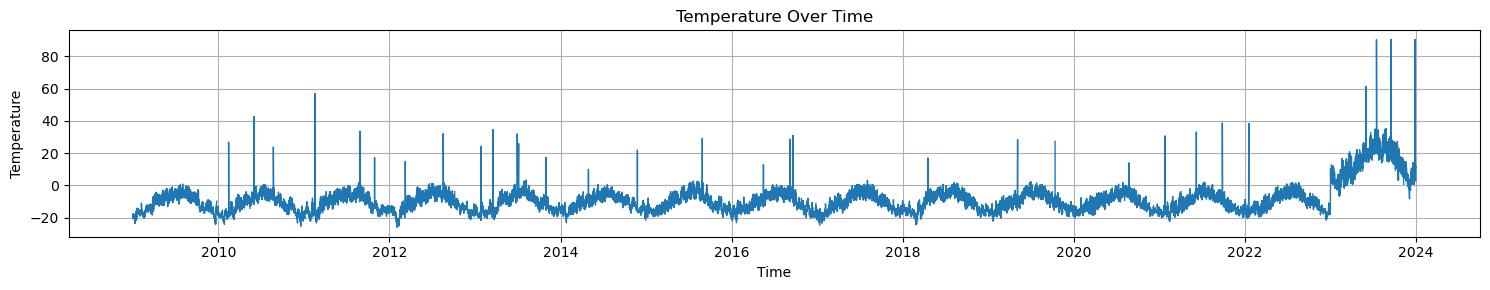

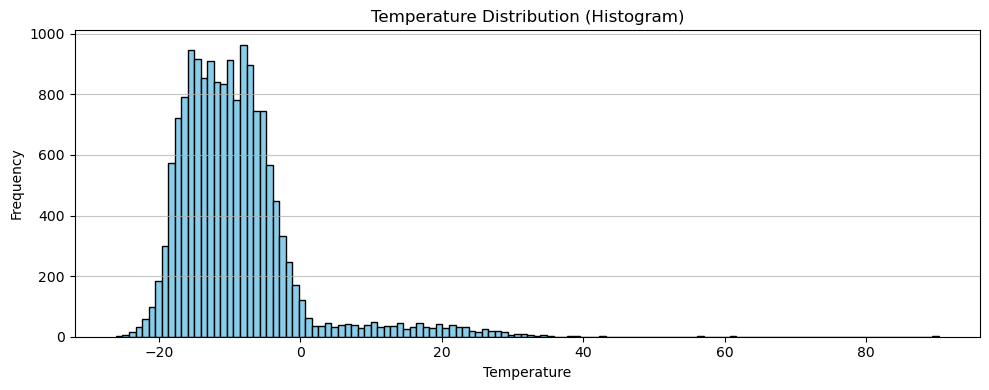

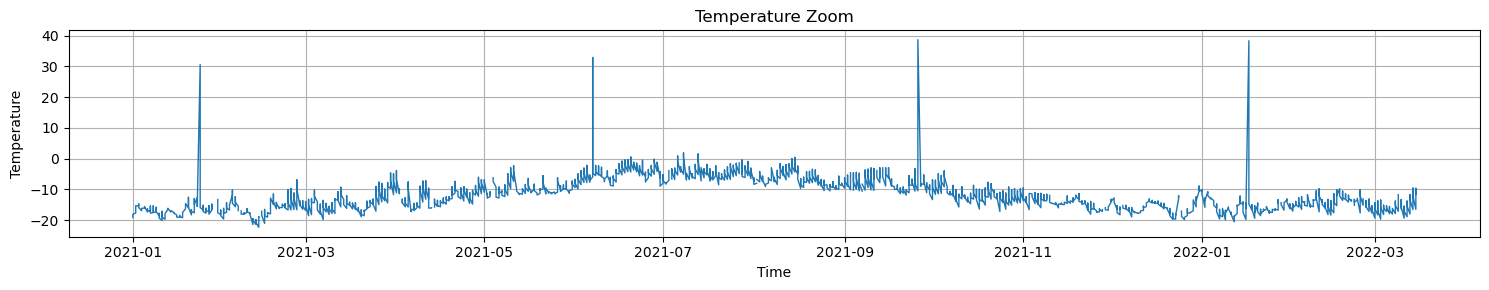

In [16]:
def plot_value_series(df:pd.DataFrame, column:str) -> None:
    """ 
    Plot the values in column in data frame df
    """
    df.plot(kind='line', y=column, figsize=(15,3))

def plot_temp_analysis(df: pd.DataFrame) -> None:
    """
    Create two plots:
    1) Temperature values over time for the whole dataframe
    2) A histogram for temperature values. 
       Choose appropriate bins enabling you to identify outliers!

    Parameters
    --------
    df: data frame containint the temperature values (temp) with potential outlier
    
    """
    x = pd.to_datetime(df["date"])
    
    # 1) Plot temperature over time
    plt.figure(figsize=(15, 3))
    plt.plot(x, df["temp"], linewidth=1)
    plt.title("Temperature Over Time")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2) Histogram for temperature values
    temp_values = df["temp"].dropna()
    bins = int(np.sqrt(len(temp_values)))  # simple bin rule: sqrt of sample size

    plt.figure(figsize=(10, 4))
    plt.hist(temp_values, bins=bins, color="skyblue", edgecolor="black")
    plt.title("Temperature Distribution (Histogram)")
    plt.xlabel("Temperature")
    plt.ylabel("Frequency")
    plt.grid(axis="y", alpha=0.75)
    plt.tight_layout()
    plt.show()

    # 3) Zoomed in
    start = pd.Timestamp("2021-01-01")
    end = pd.Timestamp("2022-03-15")
    ts = pd.to_datetime(x)
    mask = (ts >= start) & (ts <= end)
    plt.figure(figsize=(15, 3))
    plt.plot(ts[mask], df.loc[mask, "temp"], linewidth=1)
    plt.title("Temperature Zoom")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_temp_analysis(weather_data)

#### Remove temperature outliers
Implement the below function using the strategy you defined above to get rid of the temperature outliers

In [17]:
def handle_temp_outliers(noisy_data) -> pd.DataFrame:
    """
    Parameters
    --------
    noisy_data: data frame that contains temperature outliers ('temp' column)

    Returns
    --------
    cleaned_data: data frame with temperature outliers removed/handled
    """
    cleaned_data = noisy_data.copy()
    s = cleaned_data["temp"].astype(float)

    win = 31
    med = s.rolling(win, center=True, min_periods=win // 2).median()
    mad = (s - med).abs().rolling(win, center=True, min_periods=win // 2).median()
    sigma = 1.4826 * mad

    mask = (s - med).abs() > 3 * sigma
    cleaned_data["temp"] = s.where(~mask, med)

    return cleaned_data

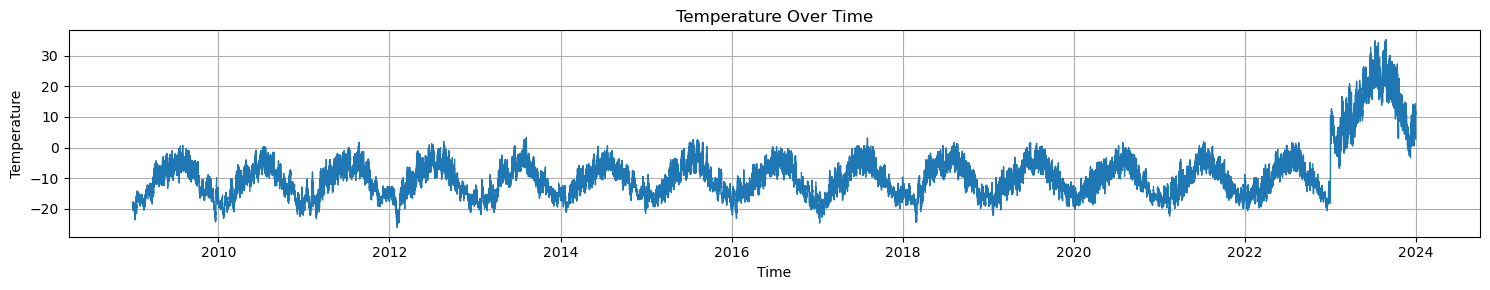

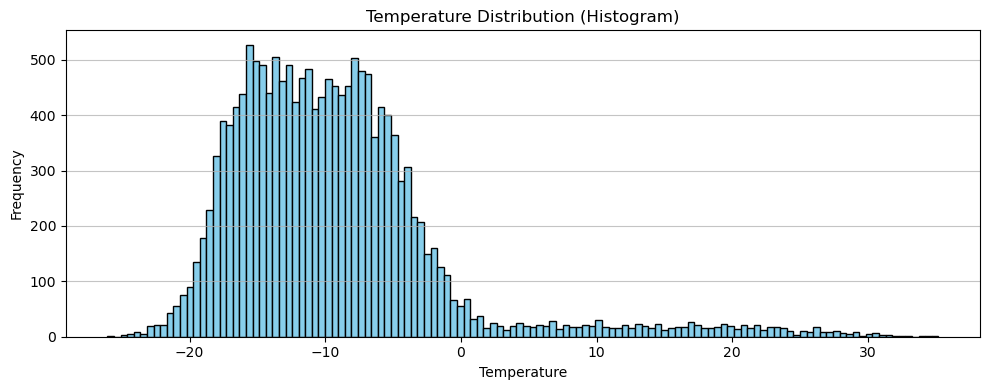

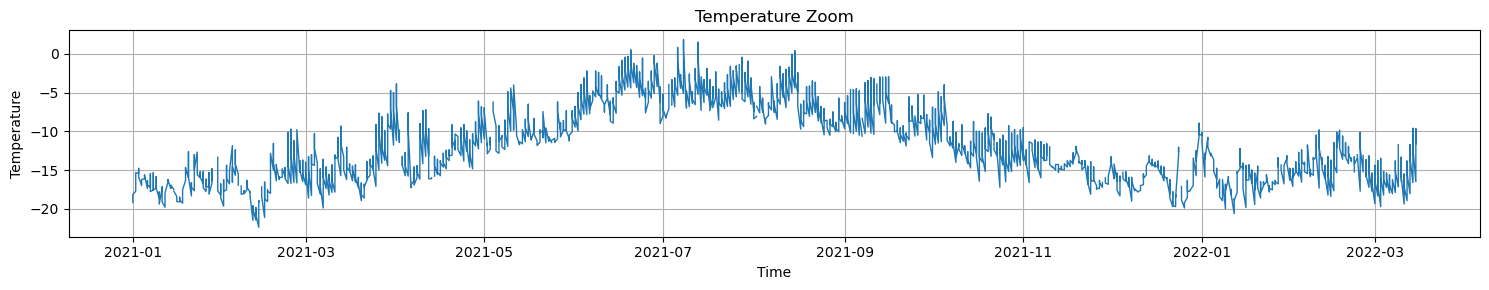

count    16098.000000
mean        -9.312846
std          8.089690
min        -26.055556
25%        -14.722222
50%        -10.444444
75%         -6.166667
max         35.200000
Name: temp, dtype: float64


In [18]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_cleaned = handle_temp_outliers(weather_data)
plot_temp_analysis(weather_data_cleaned)
print(weather_data_cleaned['temp'].describe())

#### Data inspection
Check the occurance of the non-numeric values in the precipitation data. You can check the file `data/weather/weather_description_<year>.txt`, which might have additional clues what is going on.

Implement the function below and return a list of the non-numeric values that occur in the `precip` column of `daily_weather_data`. Make sure to only return every unique value once! 

In [19]:
def get_non_numeric_precip_values(df:pd.DataFrame) -> typing.Set[str]:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    non_numeric_values: list of unique non-numeric values. 
    Do not return duplicate values in the list!
    """
    non_numeric_values = set()

    # YOUR CODE HERE
    df_filter = df["precip"].astype(str).str.replace('.', '', 1).str.isnumeric() == False
    non_numeric_values = set(df.loc[df_filter, "precip"].astype(str).unique())

    return non_numeric_values

In [20]:
# DO NOT MODIFY OR COPY THIS CELL!!
non_numeric_values = get_non_numeric_precip_values(daily_weather_data)
print(f"\nnon-numeric values values: {non_numeric_values}")


non-numeric values values: {'traces'}


#### Fix non-numeric values
Replace non-numeric values with some appropriate numerical values and convert the column to a more suitable data type.
To get an idea, what appropriate values might be, check the file `data/weather/weather_description_<year>.txt` and the other numeric values in the `precip` column.

In [21]:
def fix_precip_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    ret_df: data frame with fixed precip values
    """
    ret_df = df.copy()

    # YOUR CODE HERE
    ret_df["precip"] = ret_df["precip"].astype(str).str.replace('traces', '0.05')
    ret_df["precip"] = ret_df["precip"].astype(float)

    return ret_df

In [22]:
daily_weather_data_fixed_precip = fix_precip_values(daily_weather_data)

In [23]:
unique_values = pd.unique(daily_weather_data_fixed_precip['precip'].values.ravel())
unique_values = np.sort(unique_values)
print(unique_values[:10])

[0.   0.05 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8 ]


In [24]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
assert pd.api.types.is_float_dtype(daily_weather_data_fixed_precip['precip'].dtype), "precip should now be a float column!!"
assert daily_weather_data_fixed_precip.shape == daily_weather_data.shape, "do not remove or add rows!"

unique_values = pd.unique(daily_weather_data_fixed_precip['precip'].values.ravel())
unique_values = np.sort(unique_values)
print(unique_values[:10])
assert np.isclose(unique_values[0], 0.0), "values for traces should be greater than 0.0mm!"
assert np.isclose(unique_values[2], 0.1), "values for traces should be smaller than 0.1mm!"


[0.   0.05 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8 ]


In [25]:
# DO NOT MODIFY OR COPY THIS CELL!!
def fix_values_daily(data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    complete_data = data.copy()
    complete_data = fix_precip_values(complete_data)
    
    return complete_data

   
def handle_outliers(data):
    """ 
    Parameters
    --------
    data: data frame containing outlier values 
    
    Returns
    --------
    complete_data: data frame not containing any outlier values
    """
    complete_data = data.copy()
    complete_data = handle_temp_outliers(complete_data)
    
    return complete_data

In [26]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_finished = fix_values_daily(daily_weather_data)
weather_data_finished = handle_outliers(weather_data)

In [27]:
weather_data_finished

date  airPressure  skyCover       temp  hum windDir  \
year month day hour                                                             
2009 1     1   7    2009-01-01        999.7        10 -20.277778   79       W   
               14   2009-01-01        998.8         5 -17.833333   71      NW   
               19   2009-01-01       1000.7        10 -18.777778   72      NW   
           2   7    2009-01-02        999.6        10 -19.444444   67     NaN   
               14   2009-01-02        998.5         9 -18.500000   66       W   
...                        ...          ...       ...        ...  ...     ...   
2023 12    30  14   2023-12-30        993.2         4  11.900000   58       W   
               19   2023-12-30        993.6         0   7.100000   78       W   
           31  7    2023-12-31        988.8        10   3.200000   96      SE   
               14   2023-12-31        985.1        10   3.700000   88     NaN   
               19   2023-12-31        984.1         9   2.900000   89       N   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2  
...                        ...  
2023 12    30  14            3  
               19            2  
           31  7             2  
               14            0  
               19            1  

[16434 rows x 7 columns]

## Aggregate values

Aggregate the observations on a daily basis. Return a data frame with a hierarchical index (levels `year`, `month` and `day`) and the following daily aggregations as columns:

- `temp_dailyMin`: minimum of `temp`
- `temp_dailyMax`: max of `temp`
- `temp_dailyMean`: mean of `temp`
- `temp_dailyMedian`: median of `temp`

- `hum_dailyMin`: min of `hum`
- `hum_dailyMax`: max of `hum`
- `hum_dailyMean`: mean of `hum`

- `wind_dailyMean`: mean of `windBeauf`
- `wind_dailyMax`: max of `windBeauf`
- `wind_dailyMin`: min of `windBeauf`

Additionally merge the precipitation values from the `daily_weather_data` dataframe also into the newly created dataframe.


In [28]:
def aggregate_daily(hourly_data, daily_data):
    # YOUR CODE HERE
    hourly = hourly_data.reset_index().drop(columns=["hour"])
    dd = daily_data.reset_index()

    group_keys = ["year", "month", "day"]

    daily = (
        hourly.groupby(group_keys)
        .agg(
            temp_dailyMin=("temp", "min"),
            temp_dailyMax=("temp", "max"),
            temp_dailyMean=("temp", "mean"),
            temp_dailyMedian=("temp", "median"),
            hum_dailyMin=("hum", "min"),
            hum_dailyMax=("hum", "max"),
            hum_dailyMean=("hum", "mean"),
            wind_dailyMean=("windBeauf", "mean"),
            wind_dailyMax=("windBeauf", "max"),
            wind_dailyMin=("windBeauf", "min"),
        )
        .reset_index()
    )

    daily["date"] = pd.to_datetime(daily[["year", "month", "day"]])
    dd["date"] = pd.to_datetime(dd[["year", "month", "day"]])

    merged = (
        daily.merge(dd[["date", "precip", "precipType"]], on="date", how="outer")
             .drop(columns=["date"])
             .set_index(group_keys)
             .sort_index()
    )

    return merged

In [29]:
agg_daily_data = aggregate_daily(weather_data_finished, daily_weather_data_finished)

In [30]:
agg_daily_data

temp_dailyMin  temp_dailyMax  temp_dailyMean  \
year month day                                                 
2009 1     1       -20.277778     -17.833333      -18.962963   
           1       -20.277778     -17.833333      -18.962963   
           1       -20.277778     -17.833333      -18.962963   
           2       -19.444444     -18.500000      -18.888889   
           2       -19.444444     -18.500000      -18.888889   
...                       ...            ...             ...   
2023 12    30        7.100000      11.900000        9.933333   
           30        7.100000      11.900000        9.933333   
           31        2.900000       3.700000        3.266667   
           31        2.900000       3.700000        3.266667   
           31        2.900000       3.700000        3.266667   

                temp_dailyMedian  hum_dailyMin  hum_dailyMax  hum_dailyMean  \
year month day                                                                
2009 1     1          -18.777778            71            79      74.000000   
           1          -18.777778            71            79      74.000000   
           1          -18.777778            71            79      74.000000   
           2          -18.722222            66            68      67.000000   
           2          -18.722222            66            68      67.000000   
...                          ...           ...           ...            ...   
2023 12    30          10.800000            58            78      66.333333   
           30          10.800000            58            78      66.333333   
           31           3.200000            88            96      91.000000   
           31           3.200000            88            96      91.000000   
           31           3.200000            88            96      91.000000   

                wind_dailyMean  wind_dailyMax  wind_dailyMin  precip  \
year month day                                                         
2009 1     1          2.000000              2              2    0.00   
           1          2.000000              2              2    0.00   
           1          2.000000              2              2    0.00   
           2          1.666667              3              0    0.05   
           2          1.666667              3              0    0.05   
...                        ...            ...            ...     ...   
2023 12    30         2.666667              3              2    0.00   
           30         2.666667              3              2    0.00   
           31         1.000000              2              0    5.40   
           31         1.000000              2              0    5.40   
           31         1.000000              2              0    5.40   

               precipType  
year month day             
2009 1     1          NaN  
           1          NaN  
           1          NaN  
           2         snow  
           2         snow  
...                   ...  
2023 12    30         NaN  
           30         NaN  
           31        rain  
           31        rain  
           31        rain  

[16434 rows x 12 columns]

In [31]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert len(agg_daily_data.columns) >= 11, "according to the instructions, the dataframe should have >= 13 columns"
assert len(agg_daily_data.index.levels) == 3, "according to the instructions, the dataframe should have a multi-index with 2 levels"
assert len(agg_daily_data) > 4000 
assert len(agg_daily_data.columns) >= 11 
assert len(agg_daily_data.index.levels) == 3 
assert len(agg_daily_data.index.levels[0]) == 15 
assert len(agg_daily_data.index.levels[1]) == 12

## Merge cyclist and weather datasets

Merge the `agg_daily_data` and `data_cyclists` datasets.
Both dataframes should now be on a daily index. 
Beware that both datasets contain rows that do not appear in the other dataset.

In [32]:
def merge_data(weather_df, traffic_df):
    """ 
    Parameters
    --------
    weather_df: daily weather data frame
    traffic_df: traffic data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both daily weather observations and traffic incidents
    """
    # YOUR CODE HERE
    merged_data = (
        weather_df
        .join(traffic_df[["number", "day_of_week"]], how="outer")
        .sort_index()
    )

    return merged_data

data_merged = merge_data(agg_daily_data, data_cyclists)
data_merged.head(13600)

temp_dailyMin  temp_dailyMax  temp_dailyMean  \
year month day                                                 
2009 1     1       -20.277778     -17.833333      -18.962963   
           1       -20.277778     -17.833333      -18.962963   
           1       -20.277778     -17.833333      -18.962963   
           2       -19.444444     -18.500000      -18.888889   
           2       -19.444444     -18.500000      -18.888889   
...                       ...            ...             ...   
2021 5     29       -9.944444      -7.333333       -9.018519   
           30      -11.222222     -10.500000      -10.888889   
           30      -11.222222     -10.500000      -10.888889   
           30      -11.222222     -10.500000      -10.888889   
           31      -10.055556      -7.333333       -8.574074   

                temp_dailyMedian  hum_dailyMin  hum_dailyMax  hum_dailyMean  \
year month day                                                                
2009 1     1          -18.777778            71            79      74.000000   
           1          -18.777778            71            79      74.000000   
           1          -18.777778            71            79      74.000000   
           2          -18.722222            66            68      67.000000   
           2          -18.722222            66            68      67.000000   
...                          ...           ...           ...            ...   
2021 5     29          -9.777778            35            62      50.333333   
           30         -10.944444            63            75      68.666667   
           30         -10.944444            63            75      68.666667   
           30         -10.944444            63            75      68.666667   
           31          -8.333333            47            60      51.333333   

                wind_dailyMean  wind_dailyMax  wind_dailyMin  precip  \
year month day                                                         
2009 1     1          2.000000              2              2    0.00   
           1          2.000000              2              2    0.00   
           1          2.000000              2              2    0.00   
           2          1.666667              3              0    0.05   
           2          1.666667              3              0    0.05   
...                        ...            ...            ...     ...   
2021 5     29         3.000000              3              3    0.10   
           30         3.333333              4              3    1.30   
           30         3.333333              4              3    1.30   
           30         3.333333              4              3    1.30   
           31         2.333333              3              2    0.05   

               precipType  number day_of_week  
year month day                                 
2009 1     1          NaN     NaN         NaN  
           1          NaN     NaN         NaN  
           1          NaN     NaN         NaN  
           2         snow     NaN         NaN  
           2         snow     NaN         NaN  
...                   ...     ...         ...  
2021 5     29        rain  2779.0    Saturday  
           30        rain  2122.0      Sunday  
           30        rain  2122.0      Sunday  
           30        rain  2122.0      Sunday  
           31        rain  3930.0      Monday  

[13600 rows x 14 columns]

In [33]:
# DO NOT MODIFY OR COPY THIS CELL!!
data_merged = merge_data(agg_daily_data, data_cyclists)
data_merged

temp_dailyMin  temp_dailyMax  temp_dailyMean  \
year month day                                                 
2009 1     1       -20.277778     -17.833333      -18.962963   
           1       -20.277778     -17.833333      -18.962963   
           1       -20.277778     -17.833333      -18.962963   
           2       -19.444444     -18.500000      -18.888889   
           2       -19.444444     -18.500000      -18.888889   
...                       ...            ...             ...   
2023 12    30        7.100000      11.900000        9.933333   
           30        7.100000      11.900000        9.933333   
           31        2.900000       3.700000        3.266667   
           31        2.900000       3.700000        3.266667   
           31        2.900000       3.700000        3.266667   

                temp_dailyMedian  hum_dailyMin  hum_dailyMax  hum_dailyMean  \
year month day                                                                
2009 1     1          -18.777778            71            79      74.000000   
           1          -18.777778            71            79      74.000000   
           1          -18.777778            71            79      74.000000   
           2          -18.722222            66            68      67.000000   
           2          -18.722222            66            68      67.000000   
...                          ...           ...           ...            ...   
2023 12    30          10.800000            58            78      66.333333   
           30          10.800000            58            78      66.333333   
           31           3.200000            88            96      91.000000   
           31           3.200000            88            96      91.000000   
           31           3.200000            88            96      91.000000   

                wind_dailyMean  wind_dailyMax  wind_dailyMin  precip  \
year month day                                                         
2009 1     1          2.000000              2              2    0.00   
           1          2.000000              2              2    0.00   
           1          2.000000              2              2    0.00   
           2          1.666667              3              0    0.05   
           2          1.666667              3              0    0.05   
...                        ...            ...            ...     ...   
2023 12    30         2.666667              3              2    0.00   
           30         2.666667              3              2    0.00   
           31         1.000000              2              0    5.40   
           31         1.000000              2              0    5.40   
           31         1.000000              2              0    5.40   

               precipType  number day_of_week  
year month day                                 
2009 1     1          NaN     NaN         NaN  
           1          NaN     NaN         NaN  
           1          NaN     NaN         NaN  
           2         snow     NaN         NaN  
           2         snow     NaN         NaN  
...                   ...     ...         ...  
2023 12    30         NaN     NaN         NaN  
           30         NaN     NaN         NaN  
           31        rain     NaN         NaN  
           31        rain     NaN         NaN  
           31        rain     NaN         NaN  

[16434 rows x 14 columns]

## Multiple Choice Questions

Question 1: Create a scatterplot with minimum daily temperature on the x-axis and the number of cyclists on the y-axis. Which of the following statement(s) about the scatterplot is/are correct?

a) The correlation between minimum daily temperature and the number of cyclists is negative.

b) The higher the minimum daily temperatur, the more cyclists are counted.

c) The association between minimum daily temperature and the number of cyclists is u-shaped.

d) There is no association between minimum daily temperature and the number of cyclists. 

In [34]:
answer_1 = {"a": 0, "b": 1, "c": 0, "d": 0}

In [35]:
# TEST (will be hidden in lab exam)
assert answer_1["a"] == 0
assert answer_1["b"] == 1
assert answer_1["c"] == 0
assert answer_1["d"] == 0


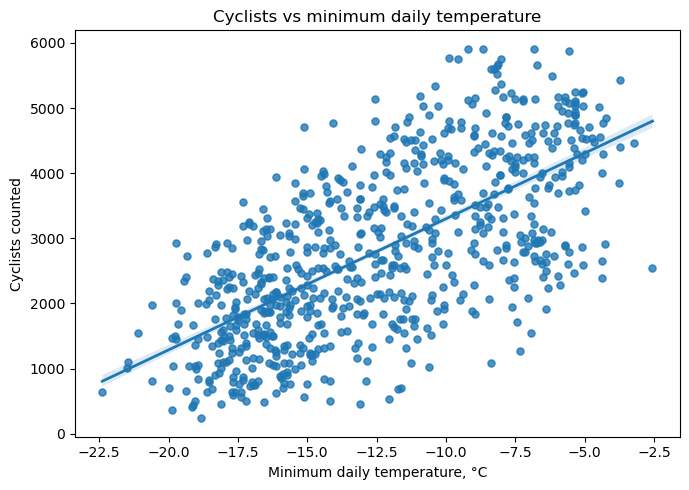

Pearson r = 0.665, p value = 3.77e-280


In [37]:
from scipy.stats import pearsonr
x_col = "temp_dailyMin"   # change if your min temp column has a different name
y_col = "number"

plot_df = (
    data_merged[[x_col, y_col]]
    .dropna()
    .rename(columns={x_col: "min_temp_c", y_col: "cyclists"})
)

plt.figure(figsize=(7, 5))
sns.regplot(
    data=plot_df,
    x="min_temp_c",
    y="cyclists",
    scatter_kws={"alpha": 0.4, "s": 25},
    line_kws={"linewidth": 2}
)
plt.xlabel("Minimum daily temperature, °C")
plt.ylabel("Cyclists counted")
plt.title("Cyclists vs minimum daily temperature")
plt.tight_layout()
plt.show()

r, p = pearsonr(plot_df["min_temp_c"], plot_df["cyclists"])
print(f"Pearson r = {r:.3f}, p value = {p:.3g}")

/tmp/ipykernel_349/3066950987.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("day_of_week", as_index=False)["number"].mean()


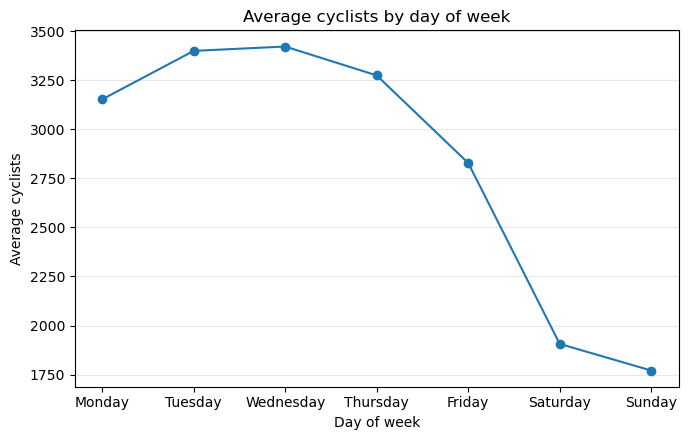

/tmp/ipykernel_349/3066950987.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["season","day_of_week"], as_index=False)["number"]


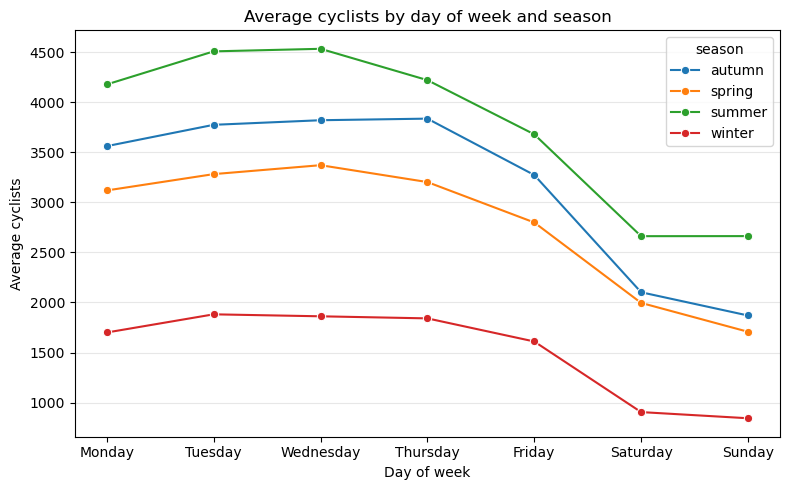

In [41]:
# YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Day of week line plot
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

wk = (
    data_merged[["day_of_week","number"]]
    .dropna()
    .assign(day_of_week=lambda d: pd.Categorical(d["day_of_week"], categories=order, ordered=True))
    .groupby("day_of_week", as_index=False)["number"].mean()
    .sort_values("day_of_week")
)

plt.figure(figsize=(7, 4.5))
plt.plot(wk["day_of_week"], wk["number"], marker="o")
plt.xlabel("Day of week")
plt.ylabel("Average cyclists")
plt.title("Average cyclists by day of week")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Weekly pattern by season, fix uses a single reset frame
tmp = data_merged.reset_index()[["year","month","day","day_of_week","number"]].copy()

def to_season(m):
    if m in [12, 1, 2]:
        return "winter"
    if m in [3, 4, 5]:
        return "spring"
    if m in [6, 7, 8]:
        return "summer"
    return "autumn"

tmp["season"] = tmp["month"].map(to_season)
tmp["day_of_week"] = pd.Categorical(tmp["day_of_week"], categories=order, ordered=True)

wk_season = (
    tmp.dropna(subset=["day_of_week","number"])
       .groupby(["season","day_of_week"], as_index=False)["number"]
       .mean()
       .sort_values(["season","day_of_week"])
)

plt.figure(figsize=(8, 5))
sns.lineplot(data=wk_season, x="day_of_week", y="number", hue="season", marker="o")
plt.xlabel("Day of week")
plt.ylabel("Average cyclists")
plt.title("Average cyclists by day of week and season")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Question 2 Make a line plot with the days of the week on the x-axis and the number of cyclists on the y-axis for each month of the year. Which of the following statements is correct?

a) The number of cyclists is stable at ~2000 throughout the year

b) During summer months (June–August) the number of cyclists on weekends is higher than on workdays.

c) In January, the number of cyclists is much higher at the beginning of the workweek (Monday) than at the end (Friday)

d) The number of cyclists is lower during the winter months, and higher during the summer. 



In [ ]:
answer_2 = ["a": 0, "b": 0, "c": 0, "d": 0]

In [ ]:
assert answer_2["a"] == 0
assert answer_2["b"] == 0
assert answer_2["c"] == 0
assert answer_2["d"] == 0

In [40]:
# YOUR CODE HERE

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Choose candidates, adjust names if needed
candidates = {
    "day_type": "day_type",            # expected values like weekday, weekend
    "temp_dailyMean": "temp_dailyMean",
    "month": "month",                  # numeric month one to twelve
    "precip": "precip",                # daily precipitation
}

df = data_merged.reset_index().copy()

# If your frame has day_of_week but not day_type, derive a simple day_type
if "day_type" not in df.columns and "day_of_week" in df.columns:
    df["day_type"] = df["day_of_week"].isin(["Saturday","Sunday"]).map({True:"weekend", False:"weekday"})

use_cols = [c for c in candidates.values() if c in df.columns]
model_df = df[use_cols + ["number"]].dropna()

# One hot encode categoricals, keep numeric as is
X = pd.get_dummies(
    model_df.drop(columns=["number"]),
    columns=[c for c in ["day_type","month"] if c in model_df.columns],
    drop_first=True
)
y = model_df["number"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

print("R2 on test set:", round(r2_score(y_test, pred), 3))
coefs = pd.Series(lr.coef_, index=X.columns).sort_values(key=abs, ascending=False)
print("Top coefficients:")
print(coefs.head(10))

R2 on test set: 0.761
Top coefficients:
day_type_weekend   -1290.776473
month_9             1080.874603
month_10             990.044502
month_6              925.749166
month_11             849.577386
month_5              776.361427
month_3              693.773096
month_7              485.615145
month_8              393.459603
month_4              334.730035
dtype: float64


Question 3 Which of the variables in the dataset are a suitable dependent variable in a classification task?

a) day_of_week, when dichotomised into two categories (workweek and weekend)

b) temp_dailyMean

c) month

d) precip

In [ ]:
answer_3 = {"a": 0, "b": 0, "c": 0, "d": 0}

In [ ]:
assert answer_3["a"] == 1
assert answer_3["b"] == 0
assert answer_3["c"] == 1
assert answer_3["d"] == 0

Question 4 When the model performs well on the training data and poorly on new, unseen data, what is this indicative of?
a) Overfitting

b) Underfitting

c) High bias

d) High variance

In [ ]:
answer_4 = {"a": 0, "b": 0, "c": 0, "d": 0}

In [ ]:
assert answer_4["a"] == 1txt
assert answer_4["b"] == 0
assert answer_4["c"] == 0
assert answer_4["d"] == 1
